# Disclaimer

Much of this notebook was written in a quick-and-dirty ad hoc fashion to produce the plot at the end, since the goal was just data exploration.

Future contributors will appreciate it if none of this in its current form makes it into production.

# Imports

In [1]:
import json
import requests

from datetime import datetime

import pandas as pd
import numpy as np
from geopy.distance import distance

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Parameters of Interest

Modify these to find the data you're looking for.

In [2]:
start_time = int(datetime(2018, 10, 18, 15-7, 0, 0).timestamp())*1000
end_time   = int(datetime(2018, 10, 18, 16-7, 0, 0).timestamp())*1000

routes = ["14"]
stop_id = "5536"

7 is subtracted from `datetime`'s `hour` parameter to account for PDT's UTC-7 offset.  
`datetime.timestamp()` yields seconds, so it's multiplied by 1000 to yield milliseconds.

# Query GraphQL

In [3]:
# shamelessly copied from Kevin's notebook

list_string = lambda arr: f"{arr}".replace("'",'"')

query = f"""{{
  trynState(agency: "muni",
            startTime: "{start_time}",
            endTime: "{end_time}",
            routes: {list_string(routes)}) {{
    agency
    startTime
    routes {{
      rid
      stops {{
        sid
        name
        lat
        lon
      }}
      routeStates {{
        vtime
        vehicles {{
          vid
          lat
          lon
          heading
          did
        }}
      }}
    }}
  }}
}}
"""
query_url = f"https://06o8rkohub.execute-api.us-west-2.amazonaws.com/dev/graphql?query={query}"

data = requests.get(query_url).json()['data']['trynState']['routes']

# Produce Datatables

Working with pandas DataTables makes things a bit more readable and organized at the cost of speed, but if performance becomes a priority then things could be changed to use named tuples or NumPy structured arrays instead.

In [4]:
buses = pd.io.json.json_normalize(data,
                                  record_path=['routeStates', 'vehicles'],
                                  meta=['rid', ['routeStates', 'vtime']]) \
        .rename(columns={'heading': 'HEADING',
                         'lat': 'LAT',
                         'lon': 'LON',
                         'vid': 'VID',
                         'rid': 'RID',
                         'did': 'DID',
                         'routeStates.vtime': 'TIME'}) \
        .reindex(['TIME', 'RID', 'VID', 'LAT', 'LON', 'DID', 'HEADING'], axis='columns')

buses.head()

,TIME,RID,VID,LAT,LON,DID,HEADING
0,1539874823336,14,7213,37.730263,-122.429688,14___I_F00,30
1,1539874823336,14,7265,37.706417,-122.459923,14___I_F00,60
2,1539874823336,14,7215,37.793522,-122.393700,14___O_F00,135
3,1539874823336,14,7270,37.722889,-122.436325,14___O_S00,211
4,1539874823336,14,7279,37.749321,-122.418106,14___I_F00,0


In [5]:
stops = pd.io.json.json_normalize(data,
                                  record_path=['stops'],
                                  meta=['rid']) \
        .rename(columns={'name': 'NAME',
                         'lat': 'LAT',
                         'lon': 'LON',
                         'sid': 'SID',
                         'rid': 'RID'}) \
        .reindex(['RID', 'SID', 'NAME', 'LAT', 'LON'], axis='columns')
# obtain stop directions
stops['DID'] = stops['SID'].map({stop: direction['id']
                                 for route in [requests
                                               .get("http://restbus.info/api/agencies/sf-muni/"
                                                    f"routes/{route_id}")
                                               .json()['directions']
                                     for route_id in routes]
                                 for direction in route
                                 for stop in direction['stops']})
# remove stops that don't have an associated direction
stops = stops.dropna(axis='index', subset=['DID'])

stops.head()

,RID,SID,NAME,LAT,LON,DID
0,14,6498,Steuart & Mission St,37.79325,-122.39328,14___O_F00
1,14,5623,Mission St & Spear St OB,37.79239,-122.39435,14___O_F00
2,14,5579,Mission St & Beale St,37.79114,-122.39592,14___O_F00
3,14,5528,Mission St & 1st St,37.78992,-122.39749,14___O_F00
4,14,5529,Mission St & 2nd St,37.78775,-122.40024,14___O_F00


For some reason, Morse & Lowell on route 14 is listed under the route's stops, but isn't listed under any of the route's directions. Since the data is outright missing, I'm just removing any such stops for now.

# Mission & 5th, Outbound

In [6]:
# shamelessly inspired by Kevin's notebook

def get_closest_bus(stop: pd.Series, buses: pd.DataFrame):
    closest_bus = None
    closest_dist = None
    for _, bus in buses.iterrows():
        dist = distance(stop[['LAT', 'LON']],
                        bus[['LAT', 'LON']]).meters
        if closest_dist is None or closest_dist > dist:
            closest_dist = dist
            closest_bus = bus['VID']
    return closest_bus, closest_dist

In [7]:
stop = stops[stops['SID'] == stop_id].squeeze()

arrivals = pd.DataFrame([[int(time), *get_closest_bus(stop,
                                                      buses[(buses['TIME'] == time)
                                                            & (buses['DID'] == stop['DID'])])]
                         for time in sorted(buses['TIME'].unique())],
                        columns=['TIME', 'VID', 'DIST'])

The direction ID `DID` is already prepended with the route ID by specification, so there's no need to check for matching `RID` between `stop` and `buses`.

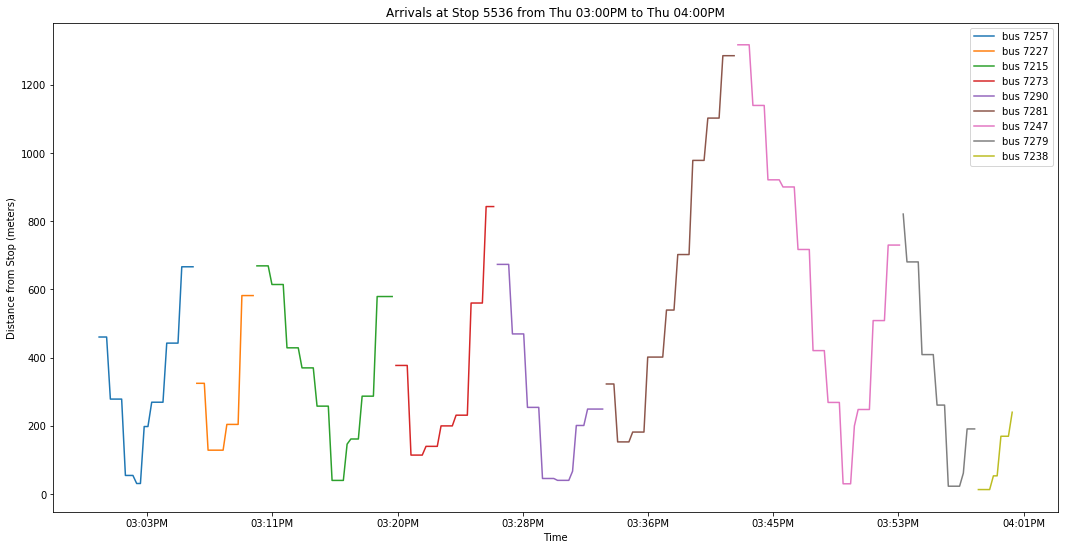

In [8]:
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)

for bus_id in arrivals['VID'].unique():
    plt.plot(*arrivals[arrivals['VID'] == bus_id][['TIME', 'DIST']].values.T,
             label=f"bus {bus_id}")
    
# format plot
ax.get_xaxis().set_major_formatter(  # convert x-axis tick labels to time of day
    FuncFormatter(lambda x, p: datetime.utcfromtimestamp(int(x)//1000).strftime('%I:%M%p')))
plt.title(f"Arrivals at Stop {stop_id}"
          f" from {datetime.utcfromtimestamp(int(start_time)//1000).strftime('%a %I:%M%p')}"
          f" to {datetime.utcfromtimestamp(int(end_time)//1000).strftime('%a %I:%M%p')}")
plt.xlabel("Time")
plt.ylabel("Distance from Stop (meters)")
plt.legend(loc='best')
          
plt.show()

# Download Arrival Data

The data will be in format specified below. The data can contain duplicate bus IDs because buses can complete the route and return back to the same stop. To handle this, values belonging to a particular bus is split when there is at least an hour gap within that data. This also means that `busID` can't be used as keys.

`values` is a 2D array with the first column being timestamps in milliseconds, and the second column being distance from the stop in meters.

```
data = [
    {
        'busID': '5442',
        'values': [
            [1539849629598, 1658.0030591047],
            [1539849659612, 1535.3449763492],
            [1539849674618, 1535.3449763492],
            [1539849689624, 1535.3449763492]
            ...
        ]
    }
    ...
]
```

In [9]:
data = []

for bus_id in arrivals['VID'].unique():
    # obtain distance data for this bus
    bus = arrivals[arrivals['VID'] == bus_id].sort_values('TIME')[['TIME', 'DIST']]
    
    # split data into groups when there is at least an hour gap between data points
    group_ids = (bus['TIME'] > (bus['TIME'].shift() + 60*60*1000)).cumsum()
    
    # store groups
    for _, group in bus.groupby(group_ids):
        data.append({
            'busID': bus_id,
            'values': eval(group.to_json(orient='values'))
        })

In [10]:
with open("arrivals.json", 'w') as f:
    f.write(json.dumps(data))